<a href="https://colab.research.google.com/github/nld-8832/stock-prediction/blob/master/1-3_LR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install yfinance --upgrade

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.54)


In [0]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression

from datetime import date

In [0]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])
df.head(10)

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2018-12-31,157.740005,1044.959961,101.570000,1501.969971,131.089996
2019-01-02,157.919998,1054.680054,101.120003,1539.130005,135.679993
2019-01-03,142.190002,1025.469971,97.400002,1500.280029,131.740005
2019-01-04,148.259995,1078.069946,101.930000,1575.390015,137.949997
2019-01-07,147.929993,1075.920044,102.059998,1629.510010,138.050003
2019-01-08,150.750000,1085.369995,102.800003,1656.579956,142.529999
2019-01-09,153.309998,1081.650024,104.269997,1659.420044,144.229996
2019-01-10,153.800003,1078.829956,103.599998,1656.219971,144.199997
2019-01-11,152.289993,1064.469971,102.800003,1640.560059,143.800003


# Find new features + Build a linear regression model

## Functions

In [0]:
def getCompany(code):
    # Get the data of the stock
    data = yf.download(code, '2018-12-31', date.today())

    data.head(10)
    return data

**Selecting means and standard deviations as secondary features**

In [0]:
def generateFeatures(data):
    # Drop unused columns
    data = pd.DataFrame(data, columns=['Close'])
    # Mean
    data['2_days_mean'] = data.Close.rolling(2, win_type='triang', on='Date').mean()
    data['5_days_mean'] = data.Close.rolling(5, win_type='triang', on='Date').mean()
    #data['30_days_mean'] = data.Close.rolling(30, win_type='triang', on='Date').mean()
    
    # Standard deviation
    data['2_days_std'] = data.Close.rolling(2, win_type='triang', on='Date').std()
    data['5_days_std'] = data.Close.rolling(5, win_type='triang', on='Date').std()
    #data['30_days_std'] = data.Close.rolling(30, win_type='triang', on='Date').std()

    #data['2_days_std_vol'] = data.Volume.rolling(2, win_type='triang', on='Date').std()
    #data['5_days_std_vol'] = data.Volume.rolling(5, win_type='triang', on='Date').std()

    #data['test'] = data['Close'] - data['Close'].shift(1)
    #data['test1'] = data['Close'] / data['Open'] 
    #data['test2'] = data.Close.pct_change()
    
    return data

Longer day interval features (30, 180, 365 days) gains a bit more performance in bigger dataset. 

In [0]:
def create_Xy(data):
    x, y, dates = [], [], []
    
    # Don't feed Close price to the model
    features = list(data.columns[1:])

    # Remove NaN mean/deviation columns at the beginning
    x = data[features].iloc[4:-1] 
    y = data['Close'].iloc[5:]

    for row_index in range(4, len(data)-1):
        dates.append(data.index[row_index])

    return x, y, dates

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Apple

In [0]:
# Apple prediction

data = getCompany('AAPL')
data = generateFeatures(data)
x, y, dates = create_Xy(data)

corr_matrix = data.corr()
print(corr_matrix)

data.head()
#print(x)
#print(y)

[*********************100%***********************]  1 of 1 completed
                Close  2_days_mean  5_days_mean  2_days_std  5_days_std
Close        1.000000     0.998169     0.993175    0.262170    0.368874
2_days_mean  0.998169     1.000000     0.996665    0.265814    0.375762
5_days_mean  0.993175     0.996665     1.000000    0.305553    0.390686
2_days_std   0.262170     0.265814     0.305553    1.000000    0.679140
5_days_std   0.368874     0.375762     0.390686    0.679140    1.000000


,Close,2_days_mean,5_days_mean,2_days_std,5_days_std
Date,,,,,
2018-12-31,157.740005,NaN,NaN,NaN,NaN
2019-01-02,157.919998,157.830002,NaN,0.127274,NaN
2019-01-03,142.190002,150.055000,NaN,11.122787,NaN
2019-01-04,148.259995,145.224998,NaN,4.292133,NaN
2019-01-07,147.929993,148.094994,149.399999,0.233347,7.221195


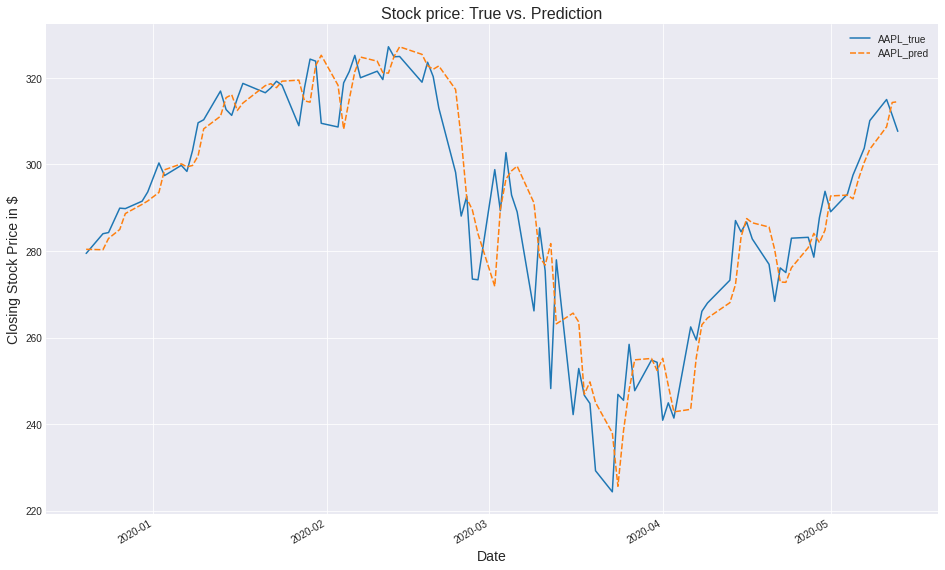

In [0]:
# splitting dataframe for training
n_train = len(data) * 7 // 10
x_train, y_train, dates_train, x_test, y_test, dates_test = x[:n_train], y[:n_train], dates[:n_train], x[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

df_plot = pd.DataFrame({"AAPL_true": y_test, 'AAPL_pred': y_predict})

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Stock price: True vs. Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()

plt.show()

In [0]:
from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, y_predict))

#Accuracy metrics
print('R2 Score:', metrics.r2_score(y_test, y_predict))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_predict))

Mean Absolute Error: 6.585539510409434
Mean Squared Error: 85.90733484974865
Root Mean Squared Error: 9.268620978859188
Mean Absolute Percentage Error: % 2.3670668688842085
R2 Score: 0.8725583125867492
Explained Variance Score: 0.8732463964518695


## Google

[*********************100%***********************]  1 of 1 completed


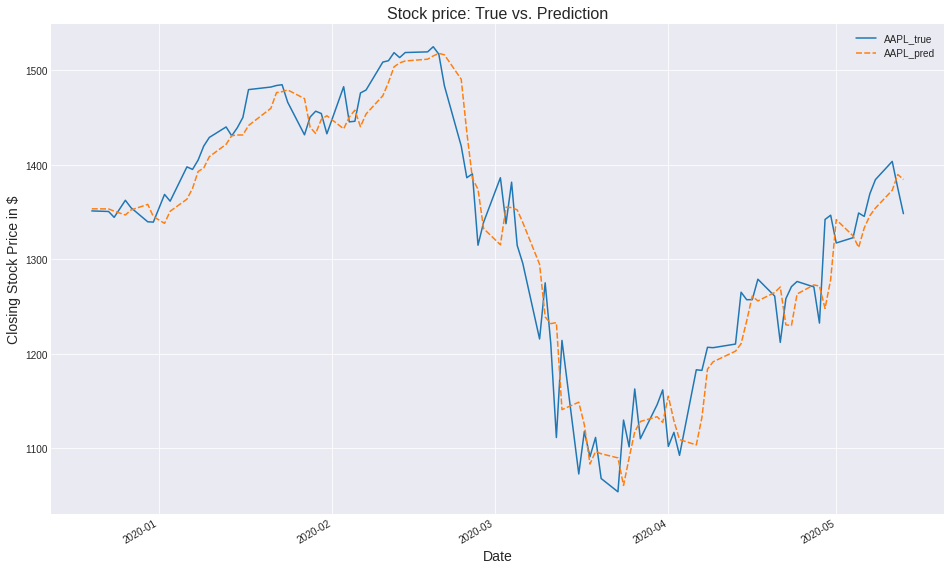

In [0]:
# Google prediction

data = getCompany('GOOGL')
data = generateFeatures(data)
x, y, dates = create_Xy(data)

# splitting dataframe for training
n_train = len(data) * 7 // 10
x_train, y_train, dates_train, x_test, y_test, dates_test = x[:n_train], y[:n_train], dates[:n_train], x[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

df_plot = pd.DataFrame({"AAPL_true": y_test, 'AAPL_pred': y_predict})

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Stock price: True vs. Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()

plt.show()

In [0]:
from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, y_predict))

#Accuracy metrics
print('R2 Score:', metrics.r2_score(y_test, y_predict))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_predict))

Mean Absolute Error: 27.185248999262214
Mean Squared Error: 1276.2327084284316
Root Mean Squared Error: 35.72439934314406
Mean Absolute Percentage Error: % 2.1186687739383587
R2 Score: 0.9247871583724881
Explained Variance Score: 0.9264295001788762


## Microsoft

[*********************100%***********************]  1 of 1 completed


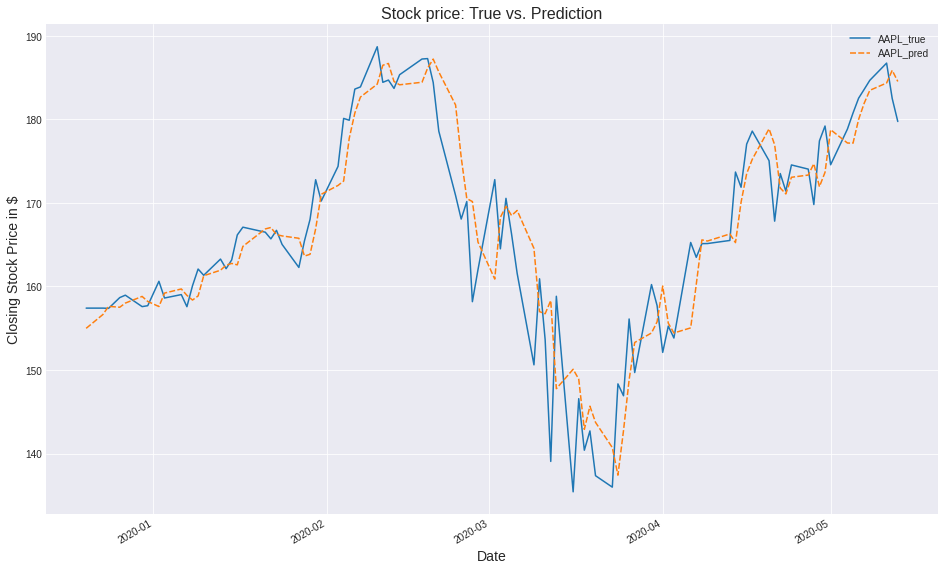

In [0]:
# Microsoft prediction

data = getCompany('MSFT')
data = generateFeatures(data)
x, y, dates = create_Xy(data)

# splitting dataframe for training
n_train = len(data) * 7 // 10
x_train, y_train, dates_train, x_test, y_test, dates_test = x[:n_train], y[:n_train], dates[:n_train], x[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

df_plot = pd.DataFrame({"AAPL_true": y_test, 'AAPL_pred': y_predict})

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Stock price: True vs. Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()

plt.show()

In [0]:
from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, y_predict))

#Accuracy metrics
print('R2 Score:', metrics.r2_score(y_test, y_predict))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_predict))

Mean Absolute Error: 3.678606475349877
Mean Squared Error: 26.750444734244173
Root Mean Squared Error: 5.172083210297778
Mean Absolute Percentage Error: % 2.27374216529801
R2 Score: 0.8317899474877554
Explained Variance Score: 0.8318904930079247


## Amazon

[*********************100%***********************]  1 of 1 completed


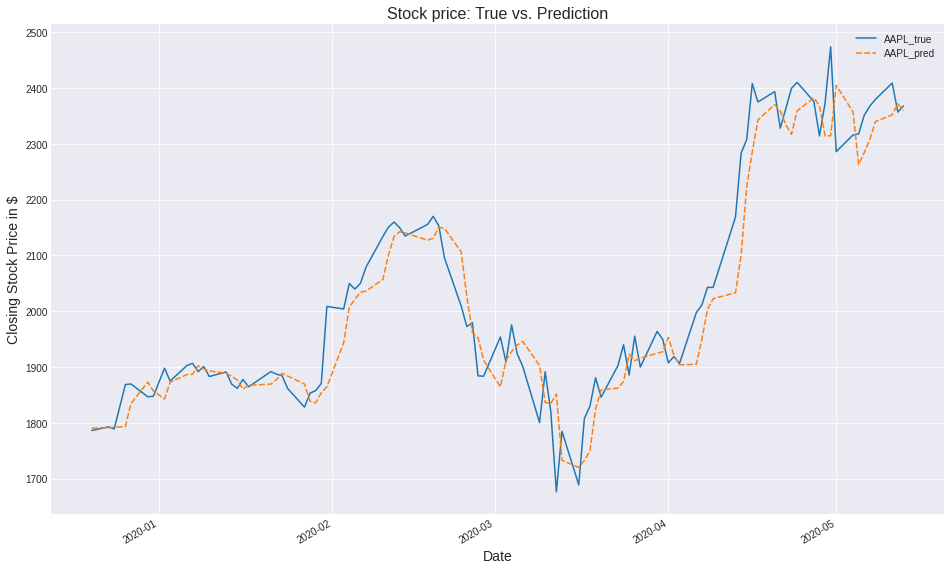

In [0]:
# Amazon prediction

data = getCompany('AMZN')
data = generateFeatures(data)
x, y, dates = create_Xy(data)

# splitting dataframe for training
n_train = len(data) * 7 // 10
x_train, y_train, dates_train, x_test, y_test, dates_test = x[:n_train], y[:n_train], dates[:n_train], x[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

df_plot = pd.DataFrame({"AAPL_true": y_test, 'AAPL_pred': y_predict})

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Stock price: True vs. Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()

plt.show()

In [0]:
from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, y_predict))

#Accuracy metrics
print('R2 Score:', metrics.r2_score(y_test, y_predict))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_predict))

Mean Absolute Error: 42.980291929690374
Mean Squared Error: 3352.0970643130167
Root Mean Squared Error: 57.89729755621601
Mean Absolute Percentage Error: % 2.095539619346176
R2 Score: 0.9201835288113687
Explained Variance Score: 0.9279046374484521


## Facebook

[*********************100%***********************]  1 of 1 completed


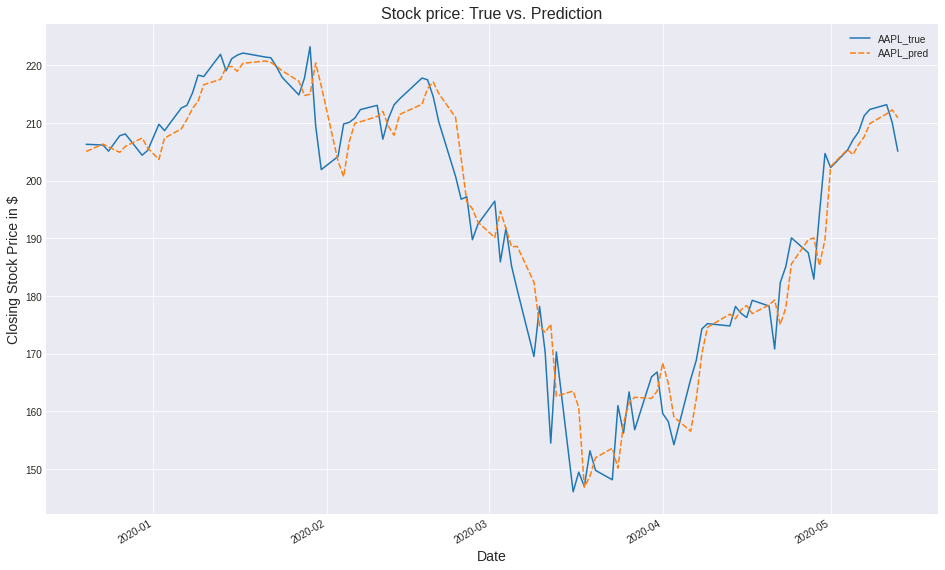

In [0]:
# Facebook prediction

data = getCompany('FB')
data = generateFeatures(data)
x, y, dates = create_Xy(data)

# splitting dataframe for training
n_train = len(data) * 7 // 10
x_train, y_train, dates_train, x_test, y_test, dates_test = x[:n_train], y[:n_train], dates[:n_train], x[n_train:], y[n_train:], dates[n_train:]

clf = LinearRegression()
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

df_plot = pd.DataFrame({"AAPL_true": y_test, 'AAPL_pred': y_predict})

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

plt.title('Stock price: True vs. Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Stock Price in $', fontsize=14)

fig.autofmt_xdate()

plt.show()

In [0]:
from sklearn import metrics

#Error metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))
print('Mean Absolute Percentage Error: %', mean_absolute_percentage_error(y_test, y_predict))

#Accuracy metrics
print('R2 Score:', metrics.r2_score(y_test, y_predict))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_predict))

Mean Absolute Error: 4.331308418874538
Mean Squared Error: 34.551158460960536
Root Mean Squared Error: 5.878023346411661
Mean Absolute Percentage Error: % 2.3658922628948056
R2 Score: 0.9323390202772187
Explained Variance Score: 0.9323720303447085
